# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [67]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import math
%matplotlib inline

In [68]:
# Format how pandas returns floats
pd.set_option('display.float_format', '{:.2f}'.format)

In [69]:
# We decided to bring in external data so we'll be reading from three files
# Write a function that loads the data and returns a dataframe
def load_file(file_name):
    file_path_name = base_path + file_name
    try:
        return pd.read_csv(file_path_name, low_memory=False)
    except:
        print 'Error: Check file path/ name'

In [70]:
# Define our base path
base_path = '/Users/joce/learning/data_science/project-3-datasets/'

In [71]:
## Load the liquor sales data into a DataFrame
df = load_file('Iowa_Liquor_sales_sample_10pct.csv')

In [72]:
## Transform the dates if needed, e.g.
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

In [73]:
# To facilitate using a bigger file later, we'll keep just the columns that are available in this dataset
all_columns = df.columns.values.tolist()
df = df.copy()[all_columns]
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.00,Bremer,1051100.00,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.00,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.00,Scott,1011100.00,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.50,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.00,Black Hawk,1011200.00,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.00,6.34
3,2016-02-03,2501,AMES,50010,85.00,Story,1071100.00,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.50,2.77
4,2015-08-18,3654,BELMOND,50421,99.00,Wright,1031080.00,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.00,5.55


To ensure accuracy, we are importing a list of Iowa zip codes, cities, counties and county numbers for the purposes of cleaning our data. We obtained our data from [here](http://www.unitedstateszipcodes.org/zip-code-database/), [here](http://www.iowayouthsurvey.iowa.gov/images/iacountiesnumbers.pdf) and [here](https://www.census.gov/geo/maps-data/data/tiger-line.html).

In [74]:
# Load in our location data file
location_data = load_file('ia_zip_city_county_sqkm.csv')
location_data = location_data.drop(location_data.columns[0], axis=1)
location_data['Zip Code'] = location_data['Zip Code'].astype(str)
location_data.head()

,Zip Code,City,County,State,County Number,Area (sqkm)
0,50001,ACKWORTH,Warren,IA,91,62.80
1,50002,ADAIR,Guthrie,IA,39,279.20
2,50003,ADEL,Dallas,IA,25,298.09
3,50005,ALBION,Marshall,IA,64,69.62
4,50006,ALDEN,Hardin,IA,42,317.75


Our hypothesis is that the demographics of an area affects the liquor sales. To test this, we brought in demographic data from [here](http://www.iowadatacenter.org/browse/ZCTAs.html).

In [75]:
# Load in our demographic data file
demo_data = load_file('IowaZIPdemos.csv')

# Remove any rows with null values
demo_data.dropna(inplace=True)


In [76]:
# All our data should be integers or floats
# Create a list of column names if those columns are objects
demo_cols = demo_data.columns.values.tolist()
object_cols = [i for i in demo_cols if demo_data[i].dtype == 'O']

# Define a function to remove symbols and convert numbers to floats
def rem_symbols(x):
    for i in [',', '%', '$', '-']:
        x = x.replace(i, '')
    try:
        return float(x)
    except:
        print x

# Convert all columns to floats
for i in object_cols:
    demo_data[i] = demo_data[i].map(rem_symbols)

# Convert zips to strings for easy comparison
demo_data['Area'] = demo_data['Area'].astype(str)
demo_data['Area'] = demo_data['Area'].map(lambda x: x.strip('.0'))
demo_data.head()

,Area,Total Pop,Median HH Inc,Per Capita Inc,White,Afr Amer,Native Amer,Asian Amer,Pac Islander,Other,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,615.00,43611.00,17803.00,594.00,3.00,1.00,0.00,0.00,2.00,...,174.00,158.00,12.00,42.00,34.00,2.85,3.21,711.00,88.80,9.70
1,50002,1339.00,32500.00,20580.00,1323.00,0.00,1.00,5.00,0.00,2.00,...,370.00,333.00,30.00,205.00,185.00,2.25,2.86,1232.00,87.60,11.20
2,50003,5835.00,47649.00,22429.00,5733.00,8.00,6.00,22.00,0.00,23.00,...,1615.00,1390.00,162.00,619.00,529.00,2.58,3.08,5816.00,91.00,24.00
3,50005,851.00,41786.00,15267.00,840.00,0.00,5.00,4.00,0.00,0.00,...,251.00,208.00,28.00,69.00,56.00,2.66,2.98,917.00,80.80,12.70
4,50006,1959.00,36494.00,16957.00,1930.00,0.00,1.00,3.00,0.00,21.00,...,547.00,477.00,43.00,220.00,194.00,2.55,3.09,1939.00,88.90,14.80


## Cleaning the data

We will run a check on zip codes before joining the liquor sales data and the location data.

In [77]:
# Create a list of unique zip codes in the liquor sales data
liquor_zips = df['Zip Code'].drop_duplicates().tolist()

# Create a list of unique zip codes as strings from the location data
ref_zips = location_data['Zip Code'].tolist()

# Create a list of zip codes that are present in the liquor sales data but not in the location data
not_found = [x for x in liquor_zips if x not in ref_zips]
print not_found

['52303', '712-2', '52087', '52084', '52036', '52733', '56201', '50300']


In [78]:
# For each 'unknown' zip code, we obtain the corresponding city, county and county number in the liquor sales data
# and return the same data for that city in our location data
for i in not_found:
    print df[['Zip Code', 'City', 'County', 'County Number']][df['Zip Code'] == i].drop_duplicates()
    city = df['City'][df['Zip Code'] == i].drop_duplicates().iloc[0].upper()
    print city
    try:
        print location_data[location_data['City']==city].drop_duplicates()
    except:
        print i, 'not in Iowa'
    print

   Zip Code          City County  County Number
78    52303  CEDAR RAPIDS   Linn          57.00
CEDAR RAPIDS
    Zip Code          City County State  County Number  Area (sqkm)
805    52401  CEDAR RAPIDS   Linn    IA             57         3.46
806    52402  CEDAR RAPIDS   Linn    IA             57        36.42
807    52403  CEDAR RAPIDS   Linn    IA             57        69.52
808    52404  CEDAR RAPIDS   Linn    IA             57       142.93
809    52405  CEDAR RAPIDS   Linn    IA             57        38.49
810    52411  CEDAR RAPIDS   Linn    IA             57        44.64

     Zip Code    City    County  County Number
114     712-2  DUNLAP  Harrison          43.00
8186    712-2  DUNLAP       NaN            nan
DUNLAP
    Zip Code    City    County State  County Number  Area (sqkm)
570    51529  DUNLAP  Harrison    IA             43       333.95

    Zip Code        City    County  County Number
267    52087  MANCHESTER  Delaware          28.00
MANCHESTER
    Zip Code        City

Based on the above, we can kind of see what these zip codes are supposed to be.  
Note: We will only be able to do this for a small dataset. As the dataset gets larger, more 'unknown' zips may appear and we may not be able to clean this manually.  

Also note that the zip for Delaware, Delaware, Iowa is in fact correct. However, as it had a small population of 159 as at the 2010 census, we will not be considering it for the purposes of our model

In [79]:
# Create a dictionary to map the correct zip codes to the incorrect ones
# We will change 52036 to 0 so as to ignore it later on
corrected_zips = {'52303': '52403',\
                  '712-2': '51529',\
                  '52087': '52057',\
                  '52084': '52804',\
                  '52036': '0',\
                  '52733': '52732',\
                  '56201': '52601',\
                  '50300': '50309'}

for i in range(len(not_found)):
    df.ix[df['Zip Code']==corrected_zips.keys()[i], 'Zip Code']=corrected_zips.values()[i]

In [80]:
# Create a new dataframe to take the merged data
df2 = df.copy()
df2.drop(['County Number', 'City', 'County'], axis=1, inplace=True)
df2 = df2.merge(location_data, how='left', on='Zip Code')
df2.drop(['State'], axis=1, inplace=True)
df2.head()

,Date,Store Number,Zip Code,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,County,County Number,Area (sqkm)
0,2015-11-04,3717,50674,1051100.00,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.00,2.38,SUMNER,Bremer,9.00,408.69
1,2016-03-02,2614,52807,1011100.00,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.50,0.40,DAVENPORT,Scott,82.00,76.47
2,2016-02-11,2106,50613,1011200.00,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.00,6.34,CEDAR FALLS,Black Hawk,7.00,329.97
3,2016-02-03,2501,50010,1071100.00,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.50,2.77,AMES,Story,85.00,155.29
4,2015-08-18,3654,50421,1031080.00,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.00,5.55,BELMOND,Wright,99.00,232.91


In [81]:
# Write a function that cross references related columns and fills the data in where it's missing
def fill_missing(related_cols, column, dataframe):
    related_cols.remove(column)
    reference = dataframe[related_cols][dataframe[column].isnull()].drop_duplicates()
    for j in range(len(related_cols)):
        col_1 = reference[related_cols[j]]
        for i in col_1:
            try:
                x = dataframe[column][(dataframe[related_cols[j]]==i) & (dataframe[column].notnull())].drop_duplicates()
                if len(x) < 2:
                    value = x.iloc[0]
                    dataframe.ix[(dataframe[related_cols[j]]==i) & (dataframe[column].isnull()), column] = value
            except:
                pass

In [82]:
# Run our function to cross check category numbers and names
fill_missing(['Category', 'Category Name'], 'Category Name', df2)
fill_missing(['Category', 'Category Name'], 'Category', df2)

# Run our function to cross check item numbers and names
fill_missing(['Item Number', 'Item Description'], 'Item Description', df2)
fill_missing(['Item Number', 'Item Description'], 'Item Number', df2)

In [83]:
# Convert all dollar columns to floats
df2['State Bottle Cost'] = df2['State Bottle Cost'].map(lambda x: x.strip('$')).astype(float)
df2['State Bottle Retail'] = df2['State Bottle Retail'].map(lambda x: x.strip('$')).astype(float)
df2['Sale (Dollars)'] = df2['Sale (Dollars)'].map(lambda x: x.strip('$')).astype(float)


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [84]:
# Extract Month and Year
df2['Month'] = df2['Date'].map(lambda x: x.month)
df2['Year'] = df2['Date'].map(lambda x: x.year)

In [85]:
# For the purposes of market research, we would want to look at full year data
# Find all the non full years in the data set
not_full_years = [i for i in df2['Year'].unique() if len(df2['Month'][df2['Year']==i].unique()) != 12]
not_full_years

[2016]

In [86]:
for i in not_full_years:
    df2 = df2.drop(df2[df2['Year']==i].index)

In [87]:
df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year'], dtype=object)

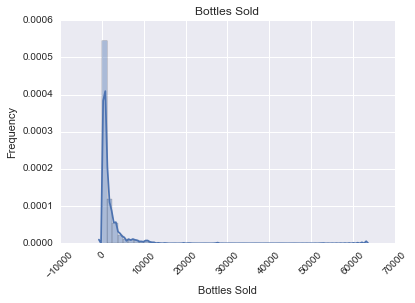

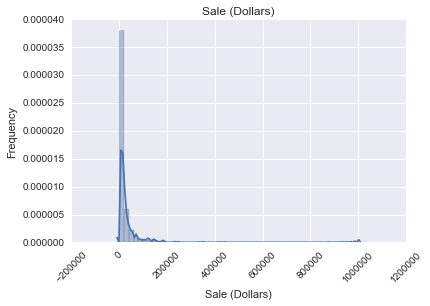

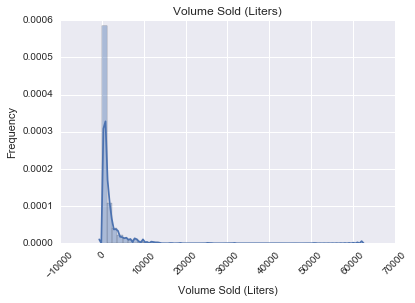

In [88]:
# Let's take a look at the distribution of 'Bottles Sold', 'Sale (Dollars)', and 'Volume Sold (Liters)'
# aggregated by store number
hist_cols = ['Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)']
for i in hist_cols:
    sns.distplot(df2.groupby('Store Number')[i].sum());
    plt.title(i);
    plt.xlabel(i);
    plt.ylabel('Frequency');
    plt.xticks(rotation=45);
    plt.show();
    print 

We can see that there are outliers in all cases.

In [89]:
# Taking a look at our top sales by zip code
top_sales = df2.copy()
top_sales.groupby('Zip Code')[['Sale (Dollars)', 'Volume Sold (Liters)']].\
sum().reset_index().sort_values(by='Sale (Dollars)', ascending=False).head(10)

,Zip Code,Sale (Dollars),Volume Sold (Liters)
94,50320,1071059.83,66445.76
90,50314,1070054.58,60405.77
353,52402,981966.84,69868.17
319,52240,876783.44,55395.70
5,50010,772044.25,52520.63
402,52807,596760.04,39658.85
87,50311,593241.84,41567.34
381,52722,566650.78,34494.76
256,51501,551026.67,36391.64
82,50266,545474.21,31487.31


In [90]:
def draw_histograms(data, col):
    sns.distplot(data[col]);
    plt.title(col);
    plt.xlabel(col);
    plt.ylabel('Frequency');
    plt.xticks(rotation=45);
    plt.show();
    print 

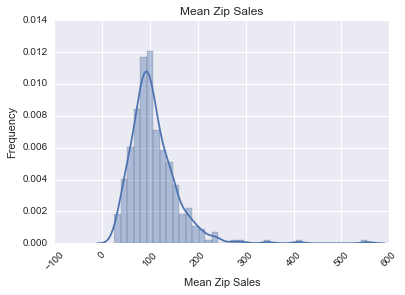

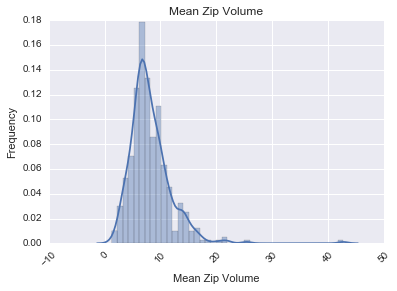

In [91]:
# Mean sales and volume by zip codes
agg_columns = ['Sale (Dollars)', 'Volume Sold (Liters)']
zip_mean = df2.groupby('Zip Code')[agg_columns].mean().reset_index()
zip_mean.columns = ['Zip Code', 'Mean Zip Sales', 'Mean Zip Volume']
zip_mean_aggs = ['Mean Zip Sales', 'Mean Zip Volume']

for i in zip_mean_aggs:
    draw_histograms(zip_mean, i)

In [92]:
# We'll take a look at our demographic data as well
demo_data.columns.values

array(['Area', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White',
       'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other',
       'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years',
       '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs',
       '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs',
       '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned',
       'Med. Home Value', 'Tot Housing units',
       'Owner occupied housing units', 'Renter occupied housing units',
       'households', 'Family households',
       'Married-couple family households', 'Single mother households',
       'Nonfamily households', 'Single Occupancy', 'Avg HH Size',
       'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad',
       '% P25-54 BA+'], dtype=object)

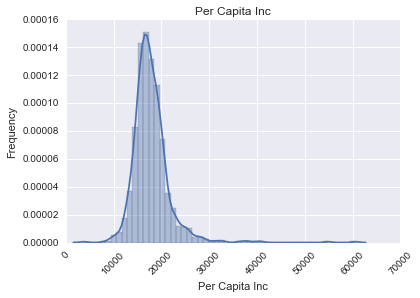

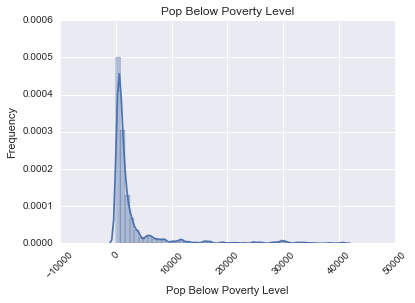

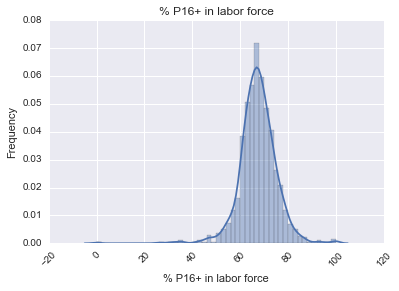

In [93]:
demo_hist_cols = ['Per Capita Inc', 'Pop Below Poverty Level', '% P16+ in labor force']
for i in demo_hist_cols:
    draw_histograms(demo_data, i)

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

For the purposes of our market research, we are interested in total sales grouped by zip codes.  
To get a fair idea of how each zip code does, we would want to remove the outlier stores (stores that do exceptionally well or poor) as these may not be a good indication of how an average store would fare in that zip code.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

In [94]:
df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year'], dtype=object)

In [95]:
# Aggregate sales and volume by stores
store_summary = df2.groupby('Store Number')[agg_columns].sum().reset_index()
store_summary.columns = ['Store Number', 'Store Sales', 'Store Volume']
store_aggs = ['Store Sales', 'Store Volume']

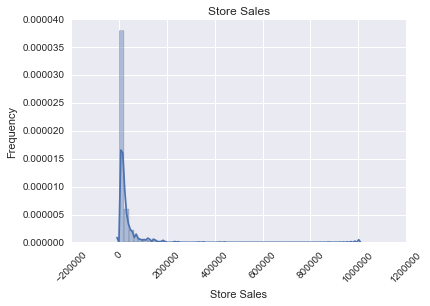

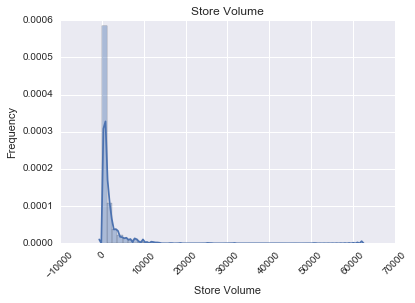

In [96]:
for i in store_aggs:
    draw_histograms(store_summary, i)

The data is still skewed but not as much as before.

In [97]:
# Now merge the summary with our cleaned dataset 
columns_required = ['Year', 'Month', 'Store Number', 'Zip Code', 'Area (sqkm)']
df3 = df2.copy()[columns_required].merge(store_summary, how='left', on='Store Number').drop_duplicates()

In [98]:
df3.head()

,Year,Month,Store Number,Zip Code,Area (sqkm),Store Sales,Store Volume
0,2015,11,3717,50674,408.69,9022.86,685.53
1,2015,8,3654,50421,232.91,9479.30,819.75
2,2015,4,2569,52402,36.42,48675.15,3607.84
3,2015,8,2596,52501,591.30,30207.68,2737.63
4,2015,6,3456,50428,316.38,69189.36,4788.19


In [99]:
# Aggregate sales and volume by zip code
zip_summary = df3.groupby('Zip Code')[store_aggs].sum().reset_index().dropna()
zip_summary.columns = ['Zip Code', 'Zip Sales - Total', 'Zip Volume - Total']
zip_aggs = ['Zip Sales - Total', 'Zip Volume - Total']

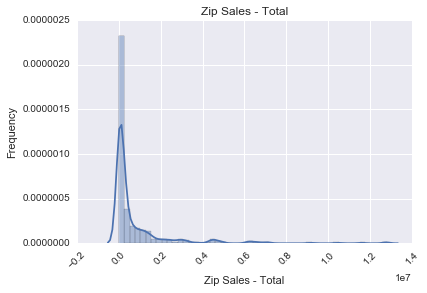

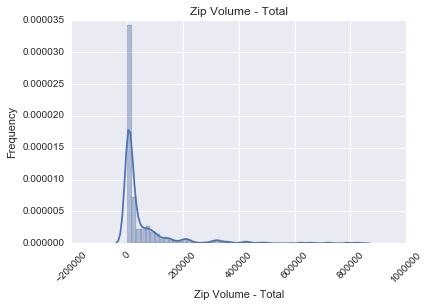

In [100]:
for i in zip_aggs:
    draw_histograms(zip_summary, i)

We won't be dropping outliers at the zip level because we want to see the zips that are doing well.

In [101]:
# Mean sales and volume by zip code
zip_mean = df3.groupby('Zip Code')[store_aggs].mean().reset_index().dropna()
zip_mean.columns = ['Zip Code', 'Zip Sales - Mean', 'Zip Volume - Mean']
zip_mean_aggs = ['Zip Sales - Mean', 'Zip Volume - Mean']

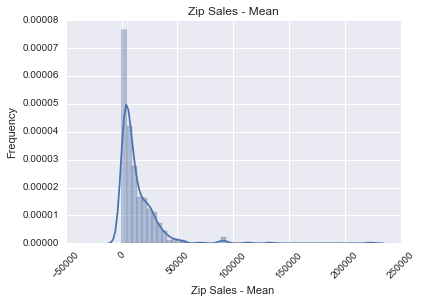

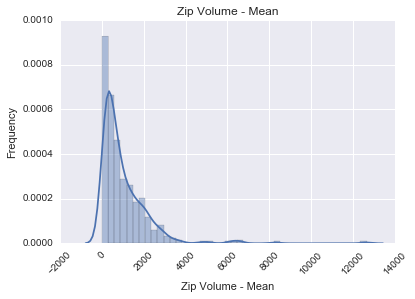

In [102]:
for i in zip_mean_aggs:
    draw_histograms(zip_mean, i)

In [103]:
df3 = df3[columns_required].merge(zip_summary, how='left', on='Zip Code').drop_duplicates()
df3 = df3.merge(zip_mean, how='left', on='Zip Code').drop_duplicates()
df3.head()

,Year,Month,Store Number,Zip Code,Area (sqkm),Zip Sales - Total,Zip Volume - Total,Zip Sales - Mean,Zip Volume - Mean
0,2015,11,3717,50674,408.69,108274.32,8226.36,9022.86,685.53
1,2015,8,3654,50421,232.91,326551.56,29382.00,9070.88,816.17
2,2015,4,2569,52402,36.42,11603625.75,829894.55,39875.00,2851.87
3,2015,8,2596,52501,591.30,3022195.08,210264.18,27474.50,1911.49
4,2015,6,3456,50428,316.38,1925031.60,141398.28,40104.83,2945.80


In [104]:
# Add a column for price per liter based on mean sales and mean volumes
df3['Dollar per liter'] = df3['Zip Sales - Total']/df3['Zip Volume - Total']
df3.head()

,Year,Month,Store Number,Zip Code,Area (sqkm),Zip Sales - Total,Zip Volume - Total,Zip Sales - Mean,Zip Volume - Mean,Dollar per liter
0,2015,11,3717,50674,408.69,108274.32,8226.36,9022.86,685.53,13.16
1,2015,8,3654,50421,232.91,326551.56,29382.00,9070.88,816.17,11.11
2,2015,4,2569,52402,36.42,11603625.75,829894.55,39875.00,2851.87,13.98
3,2015,8,2596,52501,591.30,3022195.08,210264.18,27474.50,1911.49,14.37
4,2015,6,3456,50428,316.38,1925031.60,141398.28,40104.83,2945.80,13.61


In [105]:
# Add store count
num_stores = df3[['Zip Code','Store Number']].drop_duplicates()
num_stores = num_stores.groupby('Zip Code').count().reset_index()
num_stores.columns = ['Zip Code', 'Store Count']
df3 = df3.merge(num_stores, how='left', on='Zip Code')
df3.head()

,Year,Month,Store Number,Zip Code,Area (sqkm),Zip Sales - Total,Zip Volume - Total,Zip Sales - Mean,Zip Volume - Mean,Dollar per liter,Store Count
0,2015,11,3717,50674,408.69,108274.32,8226.36,9022.86,685.53,13.16,1
1,2015,8,3654,50421,232.91,326551.56,29382.00,9070.88,816.17,11.11,3
2,2015,4,2569,52402,36.42,11603625.75,829894.55,39875.00,2851.87,13.98,28
3,2015,8,2596,52501,591.30,3022195.08,210264.18,27474.50,1911.49,14.37,11
4,2015,6,3456,50428,316.38,1925031.60,141398.28,40104.83,2945.80,13.61,4


In [106]:
# Add stores per square kilometer
df3['Stores per sqkm'] = df3['Store Count']/df3['Area (sqkm)']

In [107]:
# Add the log of sales and log of volume so that we don't get negative predictions
df3['Log Sales'] = np.log(df3['Zip Sales - Total'])
df3['Log Volume'] = np.log(df3['Zip Volume - Total'])

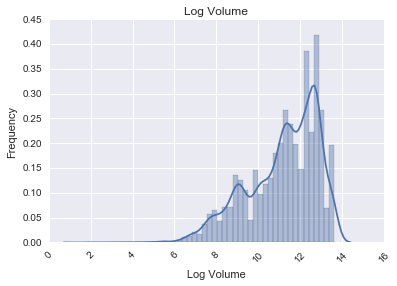

In [128]:
draw_histograms(df3, 'Log Volume')

In [108]:
# scale the demo_data
demo_data_scaled = demo_data.copy()
cols_scale = demo_data_scaled.columns.values.tolist()[1:]
scaler = StandardScaler().fit(demo_data_scaled[cols_scale])
scaled_values = scaler.transform(demo_data_scaled[cols_scale])

for i in range(len(cols_scale)):
    demo_data_scaled[cols_scale[i]] = [x[i] for x in scaled_values]

In [109]:
# Rearranging our df so that month and year are the last 2 columns
df3_columns = df3.columns.values.tolist()
df3_columns = df3_columns[2:]
df3_columns.extend(['Month', 'Year'])
df3 = df3[df3_columns]
df3.head()

,Store Number,Zip Code,Area (sqkm),Zip Sales - Total,Zip Volume - Total,Zip Sales - Mean,Zip Volume - Mean,Dollar per liter,Store Count,Stores per sqkm,Log Sales,Log Volume,Month,Year
0,3717,50674,408.69,108274.32,8226.36,9022.86,685.53,13.16,1,0.00,11.59,9.02,11,2015
1,3654,50421,232.91,326551.56,29382.00,9070.88,816.17,11.11,3,0.01,12.70,10.29,8,2015
2,2569,52402,36.42,11603625.75,829894.55,39875.00,2851.87,13.98,28,0.77,16.27,13.63,4,2015
3,2596,52501,591.30,3022195.08,210264.18,27474.50,1911.49,14.37,11,0.02,14.92,12.26,8,2015
4,3456,50428,316.38,1925031.60,141398.28,40104.83,2945.80,13.61,4,0.01,14.47,11.86,6,2015


In [110]:
model_df = df3.merge(demo_data_scaled, how='left', left_on='Zip Code', right_on='Area').drop('Area', axis=1)

In [111]:
model_df.head()

,Store Number,Zip Code,Area (sqkm),Zip Sales - Total,Zip Volume - Total,Zip Sales - Mean,Zip Volume - Mean,Dollar per liter,Store Count,Stores per sqkm,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,3717,50674,408.69,108274.32,8226.36,9022.86,685.53,13.16,1,0.00,...,0.17,0.23,-0.11,0.04,0.09,-0.12,0.01,0.11,0.30,-0.03
1,3654,50421,232.91,326551.56,29382.00,9070.88,816.17,11.11,3,0.01,...,0.05,0.10,-0.10,0.10,0.17,-0.86,-0.34,0.04,-0.29,-0.10
2,2569,52402,36.42,11603625.75,829894.55,39875.00,2851.87,13.98,28,0.77,...,5.90,6.09,4.83,6.53,6.66,-0.76,-0.14,5.98,1.39,2.46
3,2596,52501,591.30,3022195.08,210264.18,27474.50,1911.49,14.37,11,0.02,...,4.73,4.66,4.72,4.39,4.69,-0.72,-0.59,4.51,-0.74,0.16
4,3456,50428,316.38,1925031.60,141398.28,40104.83,2945.80,13.61,4,0.01,...,1.26,1.33,0.96,1.10,1.25,-0.86,-0.69,1.18,0.47,1.17


# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

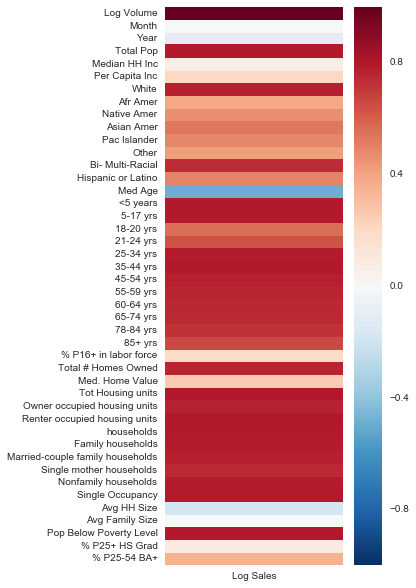

In [112]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['Log Sales']].iloc[10:]);

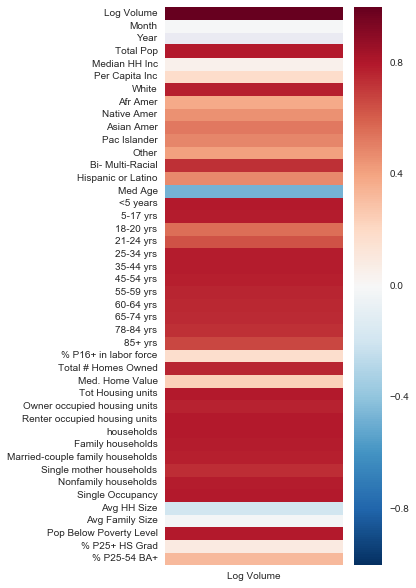

In [113]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['Log Volume']].iloc[10:]);

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [114]:
features = model_df.columns.values.tolist()
print features

['Store Number', 'Zip Code', 'Area (sqkm)', 'Zip Sales - Total', 'Zip Volume - Total', 'Zip Sales - Mean', 'Zip Volume - Mean', 'Dollar per liter', 'Store Count', 'Stores per sqkm', 'Log Sales', 'Log Volume', 'Month', 'Year', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White', 'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other', 'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years', '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs', '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs', '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned', 'Med. Home Value', 'Tot Housing units', 'Owner occupied housing units', 'Renter occupied housing units', 'households', 'Family households', 'Married-couple family households', 'Single mother households', 'Nonfamily households', 'Single Occupancy', 'Avg HH Size', 'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad', '% P25-54 BA+']


In [115]:
drop_features = ['Store Number', 'Zip Code', 'Area (sqkm)',\
                 'Zip Sales - Total', 'Zip Volume - Total', 'Zip Sales - Mean', 'Zip Volume - Mean',\
                 'Dollar per liter', 'Store Count', 'Stores per sqkm', 'Log Sales', 'Log Volume', 'Month']
for i in drop_features:
    features.remove(i)

In [116]:
model_df.dropna(inplace=True)
X = model_df[features]

In [117]:
y_sales = model_df['Log Sales']
ridge = linear_model.RidgeCV(cv=5)
model_sales = ridge.fit(X,y_sales)
print 'r-squared: {}'.format(model_sales.score(X,y_sales))
print 'alpha applied: {}'.format(model_sales.alpha_)

feature_imp = pd.DataFrame([features, model_sales.coef_.tolist()], index=['feature', 'coef']).T
feature_imp['coef'] = feature_imp['coef'].astype(float)
feature_imp = feature_imp.sort_values(by='coef', ascending=False)

r-squared: 0.807552896065
alpha applied: 0.1


In [118]:
y_volume = model_df['Log Volume']
ridge2 = linear_model.RidgeCV(cv=5)
model_volume = ridge2.fit(X,y_volume)
print 'r-squared: {}'.format(model_volume.score(X,y_volume))
print 'alpha applied: {}'.format(model_volume.alpha_)

feature_imp_v = pd.DataFrame([features, model_volume.coef_.tolist()], index=['feature', 'coef']).T
feature_imp_v['coef'] = feature_imp_v['coef'].astype(float)
feature_imp_v = feature_imp_v.sort_values(by='coef', ascending=False)

r-squared: 0.799271466792
alpha applied: 1.0


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

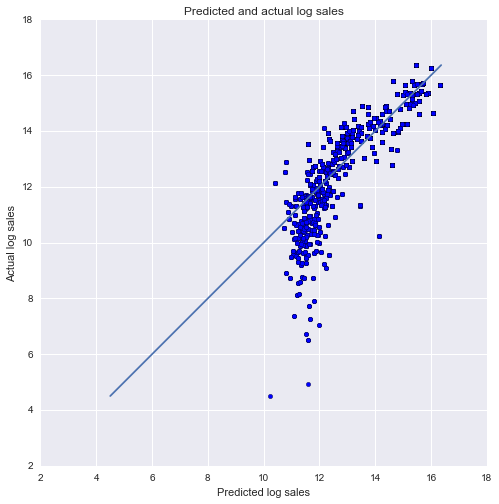

In [119]:
predicted_sales = model_sales.predict(X)
fig, ax = plt.subplots(figsize=(8,8));
plt.scatter(predicted_sales, y_sales);
plt.plot([min(y_sales), max(y_sales)], [min(y_sales), max(y_sales)], '-');
plt.title('Predicted and actual log sales');
plt.xlabel('Predicted log sales');
plt.ylabel('Actual log sales');

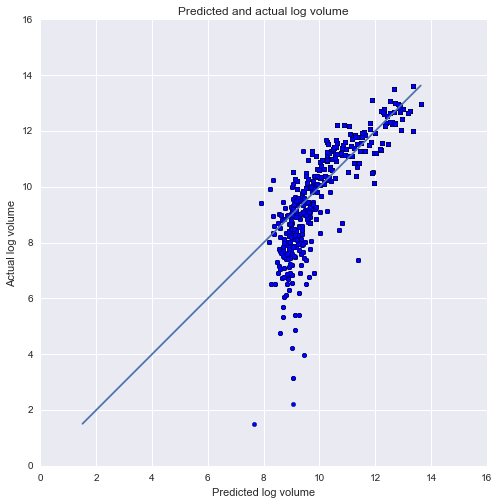

In [120]:
predicted_volume = model_volume.predict(X)
fig, ax = plt.subplots(figsize=(8,8));
plt.scatter(predicted_volume, y_volume);
plt.plot([min(y_volume), max(y_volume)], [min(y_volume), max(y_volume)], '-');
plt.title('Predicted and actual log volume');
plt.xlabel('Predicted log volume');
plt.ylabel('Actual log volume');

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.

In [121]:
# Predict sales for all zip codes
predict_df = location_data.copy()
predict_df['Year'] = 2016
predict_df = predict_df.merge(demo_data_scaled, left_on='Zip Code', right_on='Area').drop('Area', axis=1)

In [122]:
X_predict = predict_df[features]
all_sales = model_sales.predict(X_predict)
all_volume = model_volume.predict(X_predict)

In [123]:
predict_df['Predicted Log Sales'] = all_sales
predict_df['Predicted Log Volume'] = all_volume
predict_df['Predicted Total Sales'] = predict_df['Predicted Log Sales'].map(lambda x: math.exp(x))
predict_df['Predicted Total Volume'] = predict_df['Predicted Log Volume'].map(lambda x: math.exp(x))
predict_df['Predicted Dollar/liter'] = predict_df['Predicted Total Sales']/predict_df['Predicted Total Volume']

predict_df.head()

,Zip Code,City,County,State,County Number,Area (sqkm),Year,Total Pop,Median HH Inc,Per Capita Inc,...,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+,Predicted Log Sales,Predicted Log Volume,Predicted Total Sales,Predicted Total Volume,Predicted Dollar/liter
0,50001,ACKWORTH,Warren,IA,91,62.80,2016,-0.40,0.63,-0.01,...,1.59,1.06,-0.38,0.57,-0.50,10.58,8.06,39372.92,3150.14,12.50
1,50002,ADAIR,Guthrie,IA,39,279.20,2016,-0.28,-0.63,0.69,...,-1.18,-0.69,-0.30,0.37,-0.33,11.83,9.30,137998.03,10992.30,12.55
2,50003,ADEL,Dallas,IA,25,298.09,2016,0.45,1.09,1.16,...,0.35,0.41,0.48,0.93,1.12,12.77,10.19,352755.98,26595.20,13.26
3,50005,ALBION,Marshall,IA,64,69.62,2016,-0.36,0.42,-0.65,...,0.72,-0.09,-0.35,-0.76,-0.16,11.12,8.61,67620.97,5502.96,12.29
4,50006,ALDEN,Hardin,IA,42,317.75,2016,-0.18,-0.18,-0.22,...,0.21,0.46,-0.18,0.58,0.08,11.37,8.86,86486.38,7026.86,12.31


In [124]:
present_columns = ['Zip Code', 'Predicted Total Sales', 'Predicted Dollar/liter']

In [125]:
present_df = predict_df[present_columns]
present_df = present_df.merge(df3[['Zip Code', 'Store Count', 'Area (sqkm)', 'Stores per sqkm',\
                                   'Zip Sales - Total', 'Dollar per liter']],\
                              how='left', on='Zip Code').drop_duplicates()

In [126]:
top_10 = present_df.sort_values(by='Predicted Total Sales', ascending=False).head(10)
top_10

,Zip Code,Predicted Total Sales,Predicted Dollar/liter,Store Count,Area (sqkm),Stores per sqkm,Zip Sales - Total,Dollar per liter
9680,52242,192862122524.37,16.71,nan,nan,nan,nan,nan
8589,52001,12406121.08,14.73,18.00,75.06,0.24,6180863.80,14.41
9694,52246,9605325.54,15.08,4.00,23.83,0.17,2276820.48,14.17
10418,52402,8708130.75,13.87,28.00,36.42,0.77,11603625.75,13.98
8007,51503,7850960.38,14.05,15.00,311.31,0.05,4642295.18,14.11
206,50021,7349876.54,13.85,12.00,66.73,0.18,4489786.45,14.35
12043,52722,6530534.10,16.84,12.00,73.16,0.16,6754514.65,16.45
2323,50266,6503787.14,17.25,16.00,43.06,0.37,6504013.33,17.35
12860,52804,6145369.45,15.57,11.00,88.86,0.12,4970564.34,15.59
3643,50401,5859780.46,13.30,13.00,387.51,0.03,4737766.35,13.13
